In [ ]:
#hide

%load_ext autoreload
%autoreload 2

In [ ]:
#default_exp dataset

# Dataset
> Instantiates and defines the dataset class that we will be using for our project.

Our project will be utilizing pytorch to create the datasets class. This class will encapsulate all the different types of data.

In [ ]:
#hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#exporti
from torch.utils.data import Dataset
from torchvision import transforms
from transformers import DistilBertTokenizer
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import os
import torch

In [ ]:
#hide

df = pd.read_csv('train.csv')

In [ ]:
#export

class MovieDataset(Dataset):
    
    def __init__(self, 
                 poster_img_dir: str,
                 backdrop_img_dir: str,
                 ds_type: str,
                 transforms: list):
        super(MovieDataset, self).__init__()
        self.ds_type = ds_type
        self.poster_path, self.backdrop_path = poster_img_dir, backdrop_img_dir
        self.transforms = transforms
        assert self.ds_type in ['train', 'valid', 'test'], "Dataset type provided is invalid."
        self.df = pd.read_csv(f"{self.ds_type}.csv")
        print(f"{self.ds_type} dataset created!")
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx: int) -> tuple:
        """
        Returns a dict of 5 items:
        Poster Image, BackDrop Image, MetaData, Title+overview, label 
        """
        poster_img_path = os.path.join(self.poster_path, f"{self.df.iloc[idx]['id']}.jpg")
        backdrop_img_path = os.path.join(self.backdrop_path, f"{self.df.iloc[idx]['id']}.jpg")
        
        poster_img_array = Image.open(poster_img_path).convert('RGB')
        backdrop_img_array = Image.open(backdrop_img_path).convert('RGB')        
        text_inputs = f"{self.df.iloc[idx]['title']}[SEP]{self.df.iloc[idx]['overview']}"
        label = self.df.iloc[idx]['tagline']
        meta = self.df.iloc[0].drop(labels=['overview', 'title', 'tagline', 'id']).to_numpy(dtype=np.float32)
        
        sample = {"poster_img" : poster_img_array,
                  "backdrop_img" : backdrop_img_array,
                  "text_inputs" : text_inputs,
                  "meta" : meta,
                  "labels" : label}
        
        sample = self.transforms(sample)
        return ((sample["poster_img"], sample["backdrop_img"], sample["text_inputs"], sample["meta"]), sample['labels'])

Every pytorch dataset class must implement minimally the following 2 methods: dunder_len and dunder_getitem. The former implements the functionality of finding out the size of your dataset using the len() method, while the latter implements the functionality of indexing into your dataset as how you would index a list.

We will be writing most of the transformations for this dataset from scratch ourselves, since data inputs are unique and not all the features will receive the same transformations. 

In [ ]:
#export

# Tokenize concatenates the title and overview into a single example
class Tokenize(object):
    
    def __init__(self, tokenizer, input_max_length: int, labels_max_length: int):
        self.tokenizer = tokenizer
        self.input_max_length = input_max_length
        self.labels_max_length = labels_max_length
        
    def __call__(self, x: dict) -> dict:
        x['labels'] = self.tokenizer(x['labels'], return_tensors='pt', max_length=self.labels_max_length, padding='max_length', truncation=True)['input_ids'].squeeze()
        x['text_inputs'] = self.tokenizer(x['text_inputs'], return_tensors='pt', max_length=self.input_max_length, padding='max_length', truncation=True)['input_ids'].squeeze()
        return x

The first transformation we will use is tokenization. As we will be using a transformer based language model to process the text data, the tokenizer being used is the WordPiece tokenizer. This has the effect of breaking up individual words until they are meaningful expressions comprehensible by the model. 

In [ ]:
labels = df.iloc[0]['tagline']
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenized = tokenizer.tokenize(labels)
tokenized

['there', 'is', 'no', 'future', 'without', 'it', '.']

In [ ]:
#export

# Resize the images to a fixed size for batching
class RandomResizeCrop(object):
    
    def __init__(self, width: int, height: int, method: int):
        self.width, self.height = width, height
        self.method = method
    
    def __call__(self, x: dict) -> dict:
        resize = transforms.RandomResizedCrop((self.height, self.width), interpolation=self.method)
        x['poster_img'] = np.array(resize(x['poster_img']))
        x['backdrop_img'] = np.array(resize(x['backdrop_img']))
        return x

Next, as noted previously, the images are not uniformly sized, and will need to be if they are to be batched in training on the GPU. Hence, we will need to resize them. Resizing is not as straightforward as it seems. As with any kind of data augmentation, it is extremely important to visualize the results of the augmentations on the image to see if there has been any significant loss in information or interpretability. 

Additionally, we will crop the images as a form of augmentation; this will hopefully make the model more robust to variance and reduce overfitting. This can be good as some of the poster and backdrop images are exactly the same, and so cropping will hopefully increase the model's focus on specific parts of the image instead. 

If we take the particular example below on the Forrest Gump movie images, the first row's image uses nearest neighbor interpolation for the resizing, and the backdrop image in particular looks extremely poorly processed, with subjects being clouded by substantial amounts of noise. Further comparing the fourth and sixth images of hamming and lanczos interpolation, we don't see too much difference, but the feather in the backdrop image of the latter is more distinctive as its individual feathery outline can be discerned a little more clearly. 

In general, there isn't always a best interpolation method, but we always need to make sure that the data does not become too unnaturally distorted. In this case, we can stick with the default method of bilinear interpolation as the results of the resizing still seem to be ok.  

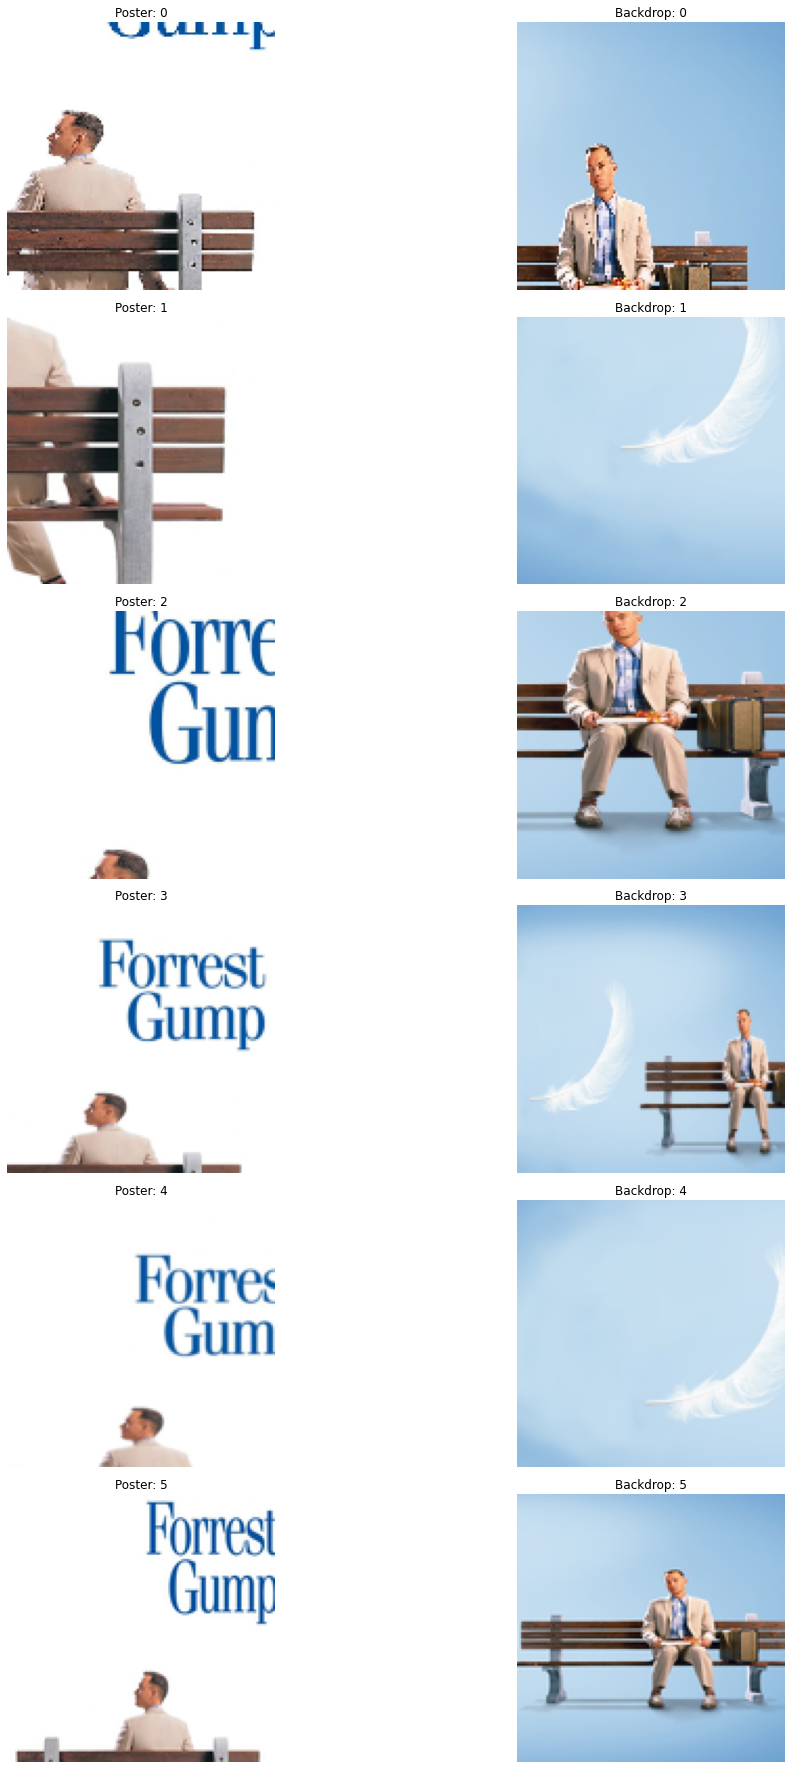

In [ ]:
resize_types = [Image.NEAREST, Image.BICUBIC, Image.BOX, Image.HAMMING, Image.BILINEAR, Image.LANCZOS]
poster_img = Image.open("poster_img/13.jpg").convert('RGB')
backdrop_img = Image.open("backdrop_img/13.jpg").convert('RGB')
x = {"poster_img" : poster_img, "backdrop_img" : backdrop_img}
width = height = 128
fig, ax = plt.subplots(len(resize_types), 2, figsize=(32, 32))
for i, t in enumerate(resize_types):
    resize = RandomResizeCrop(width=width, height=height, method=t)
    res = resize(x.copy())
    ax[i, 0].set_title(f"Poster: {i}"), ax[i, 1].set_title(f"Backdrop: {i}")
    ax[i, 0].set_axis_off(), ax[i, 1].set_axis_off()
    ax[i, 0].imshow(res["poster_img"])
    ax[i, 1].imshow(res['backdrop_img'])
fig.subplots_adjust(wspace=-0.6, hspace=0.1)

In [ ]:
#export

# ToTensor converts the numpy array to a torch Tensor of the same data type
class ToTensor(object):
    
    def __call__(self, x: dict) -> dict:
        x['poster_img'] = np.transpose(x['poster_img'], axes=(2, 0, 1))
        x['backdrop_img'] = np.transpose(x['backdrop_img'], axes=(2, 0, 1))
        x = {k : torch.Tensor(v) if isinstance(v, np.ndarray) else v for k, v in x.items()}
        return x

Next, we will convert all items in the dictionary into a torch Tensor. A torch Tensor is the basic unit in the Pytorch library, allowing for all sorts of operations to be applied onto it and its gradients to be tracked. 

In [ ]:
#export

# NormalizeStandardize scales images to between 0 and 1 before subtracting mean and dividing by std
class NormalizeStandardize(object):
    
    def __init__(self, mean: list, std: list):
        nc = len(mean)
        self.mean = torch.Tensor(mean).view(nc, 1, 1)
        self.std = torch.Tensor(std).view(nc, 1, 1)
    
    def __call__(self, x: dict) -> dict:
        poster_norm = torch.true_divide(x['poster_img'], 255.)
        backdrop_norm = torch.true_divide(x['backdrop_img'], 255.)
        x['poster_img'] = (poster_norm - self.mean) / self.std
        x['backdrop_img'] = (backdrop_norm - self.mean) / self.std
        return x

Lastly, we normalize and standardize the images. This is a standard practice with most image tasks to allow training to be more stable and to converge more quickly. Normalization refers to scaling the pixels to between 0 and 1 by dividing by 255. Standardization refers to the process ot subtracting the pixels by mean and dividing by standard deviation. In our case, as we will be using a pretrained CNN model for feature extraction, we will use the mean and standard deviation statistics from the ImageNet dataset on which the pretraining was done. 

In [ ]:
#export

class Compose(object):
    
    def __init__(self, tfms: list):
        self.tfms = tfms
        
    def __call__(self, x: dict) -> dict:
        for tfm in self.tfms:
            x = tfm(x)
        return x

We also create a small and handy class to compose all our transforms together.

We'll leave the augmentations and transformations at that for now, as there are countless possibilities to explore including lighting and affine transformations. So now, we can finally compose all our transforms together and create our train and validation datasets. We will leave the test and tagless datasets out for now.

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
input_max_length, labels_max_length = 80, 10
height = width = 128
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
tfms = Compose([Tokenize(tokenizer=tokenizer, input_max_length=input_max_length, labels_max_length=labels_max_length),
                         RandomResizeCrop(width=width, height=height, method=Image.BILINEAR),
                         ToTensor(),
                         NormalizeStandardize(mean=mean, std=std)])

poster_img_dir = "poster_img/"
backdrop_img_dir = "backdrop_img/"
train_ds = MovieDataset(poster_img_dir=poster_img_dir,
                        backdrop_img_dir=backdrop_img_dir,
                        ds_type="train",
                        transforms=tfms)

valid_ds = MovieDataset(poster_img_dir=poster_img_dir,
                        backdrop_img_dir=backdrop_img_dir,
                        ds_type="valid",
                        transforms=tfms)

train dataset created!
valid dataset created!
